In [248]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pylab 
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import os
from sklearn.compose import ColumnTransformer
from IPython.display import display
import random

# **Data Cleaning**

In [249]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [250]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

C:\Users\Ian\AppData\Local\Temp/ipykernel_8704/324537713.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train.hist(ax = axes)


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

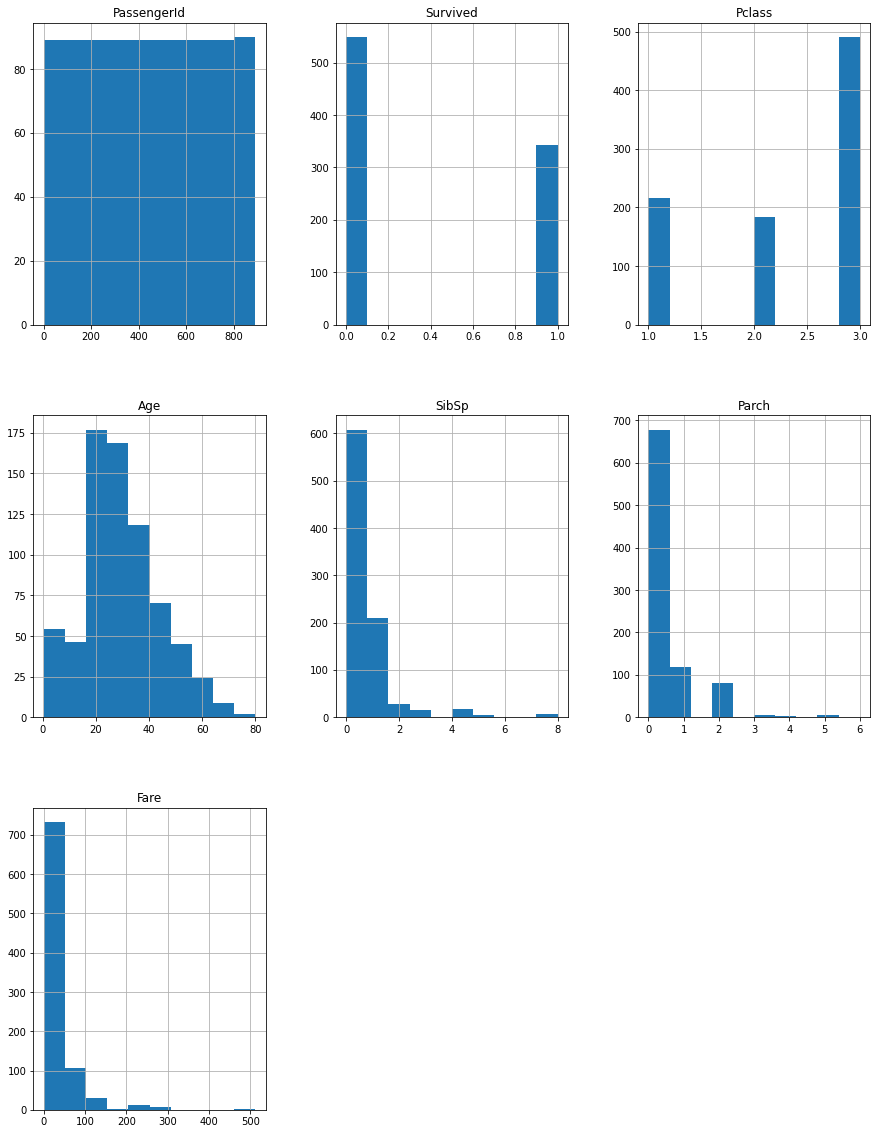

In [251]:
# distribution of each of the variables
fig = plt.figure(figsize=(15, 20))
axes = fig.gca()
train.hist(ax = axes)

**Invalid Data**

In [252]:
#deep copy of training dataset
clean_train = train.copy()
clean_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<AxesSubplot:>

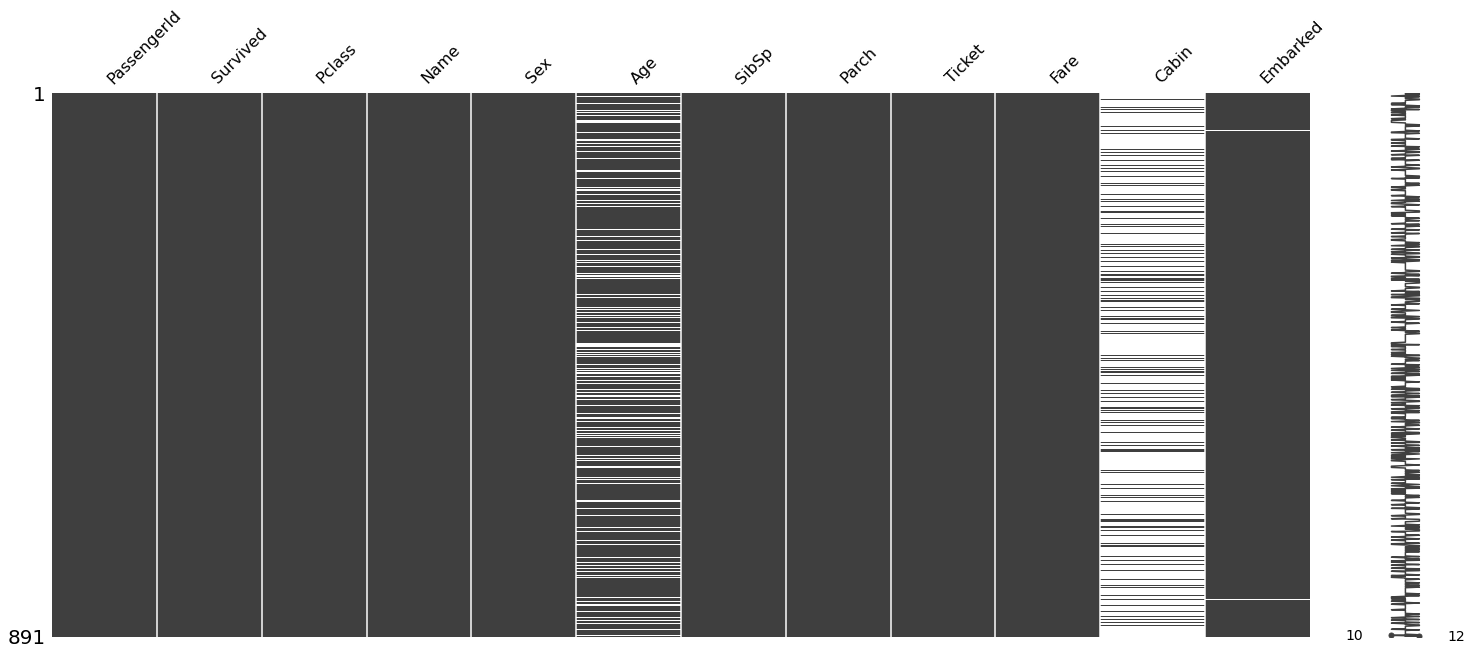

In [253]:
msno.matrix(clean_train)

In [254]:
#dropped PassengerID and Name column since all names are unique categorical values
clean_train = clean_train.drop(columns=['Name'])
clean_train = clean_train.drop(columns=['PassengerId'])

In [255]:
#clean_train['Cabin'].unique()
null_percentage = clean_train['Cabin'].isnull().mean() * 100
print("Percentage of null values in 'Cabin' column: {:.2f}%".format(null_percentage))
clean_train['Cabin'] = clean_train['Cabin'].fillna('NA') 

Percentage of null values in 'Cabin' column: 77.10%


In [256]:
#fixing invalid Cabin data

val = []

for index, row in clean_train['Cabin'].iteritems():
    if len(row) > 3 and row[3]==' ':
        count = 0;
        cabins = row.split(' ')
        for i, r in clean_train[clean_train['Cabin'] == row].iteritems():
            if(count<len(cabins)):
                val.append(cabins[count])
                count+=1
            else:
                val.append(cabins[count-1])
            
    elif row[0]=='F' and row[1]==' ':
        tmp = 'F' + str(random.randint(1, 148)) + row[1:]
        count = 0;
        cabins = tmp.split(' ')
        for i, r in clean_train[clean_train['Cabin'] == row].iteritems():
            if(count<len(cabins)):
                val.append(cabins[count])
                count+=1
            else:
                val.append(cabins[count-1])
    elif row[0]=='D'and len(row)==1:
        val.append(row+str(random.randint(1, 148)))
    else:
        val.append(row)

clean_train['New Cabin'] = pd.DataFrame(val)
clean_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,New Cabin
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NA,S,NA
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,C85
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,NA
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,C123
4,0,3,male,35.0,0,0,373450,8.0500,NA,S,NA


**Outliers**

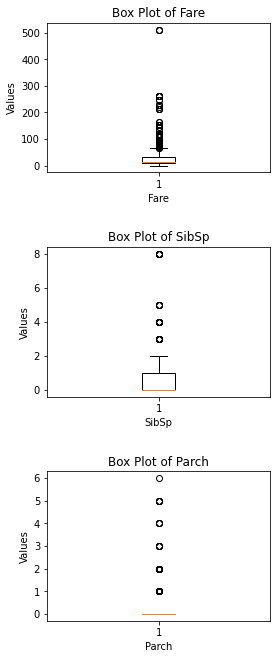

In [257]:
#columns that are skewed based on histogram; creates boxplot for skewed columns
skew = ['Fare','SibSp','Parch']

fig, axes = plt.subplots(nrows=len(skew), figsize=(4,11)) #fig contains subplot, 
                                                                     #an array of subplots

for i, column in enumerate(skew):
    axes[i].boxplot(clean_train[column])
    axes[i].set_title('Box Plot of {}'.format(column))
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Values")


plt.subplots_adjust(hspace=0.5)
#removing the outliers doesn't seem reasonable as there are only a few and the values are reasonable

**Data Imputation**

In [258]:
#Age column
clean_train['Age'].fillna(clean_train['Age'].mode().iloc[0], inplace=True)

Amount of rows that have price as 0: 15 rows


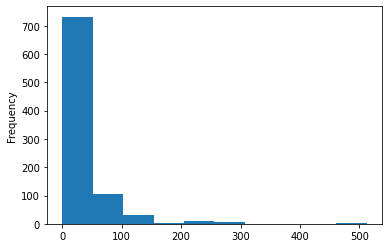

In [259]:
#Fare column

print(f"Amount of rows that have price as 0: {len(clean_train['Fare'])-len(clean_train[clean_train['Fare']>0])} rows") 

#Since distribution is heavily skewed to the right, we will find the median of price for each Ticket Class
clean_train['Fare'].plot(kind='hist')
plt.show()

def impute_median(row):
    return clean_train[clean_train['Pclass']==row['Pclass']]['Fare'].median()


clean_train['Fare'] = clean_train['Fare'].replace(0, np.nan)
missing_fares = clean_train['Fare'].isnull()
clean_train.loc[missing_fares, 'Fare'] = clean_train[missing_fares].apply(impute_median, axis=1)

**Transformation for variables with skewed data**

[Text(0.5, 0, 'Fare (Log Transformed)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Distribution of Log Transformed Fare')]

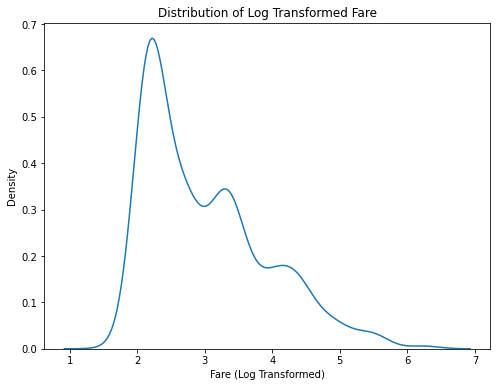

In [260]:
clean_train['Fare_log'] = np.log(clean_train['Fare'] + 1)
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=clean_train['Fare_log'], ax=ax)
ax.set(xlabel='Fare (Log Transformed)', ylabel='Density', title='Distribution of Log Transformed Fare')

In [261]:
#Embarked column
clean_train['Embarked'].fillna(clean_train['Embarked'].mode().iloc[0], inplace=True)

In [262]:
clean_train.isnull().sum(axis=0)

Survived     0
Pclass       0
Sex          0
Age          0
SibSp        0
Parch        0
Ticket       0
Fare         0
Cabin        0
Embarked     0
New Cabin    0
Fare_log     0
dtype: int64

<AxesSubplot:>

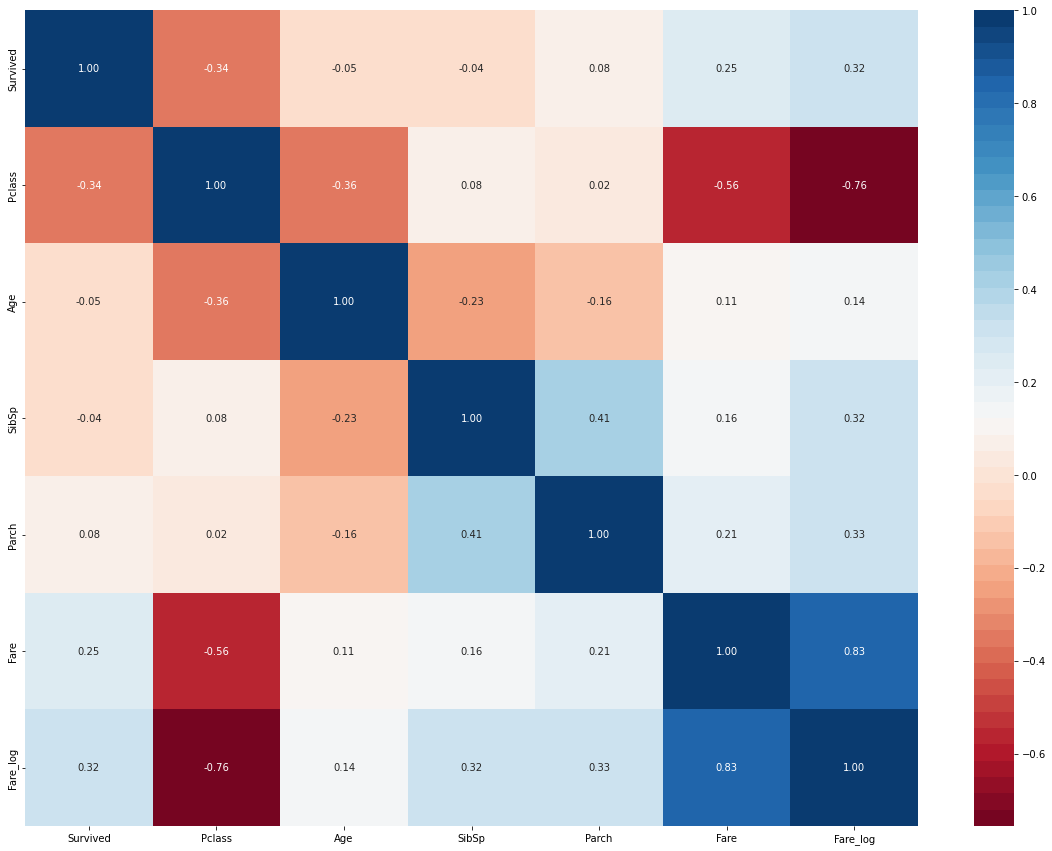

In [263]:
# correlations between the columns
plt.figure(figsize=(20, 15))
sns.heatmap(clean_train.corr(), annot=True, cmap=sns.color_palette('RdBu',50), fmt='.2f')

In [264]:
corr = clean_train.corr().abs()
sort = corr.sort_values(by=['Survived'],ascending=False)
print("Correlation of each variable to Survived:")
sort['Survived']

Correlation of each variable to Survived:


Survived    1.000000
Pclass      0.338481
Fare_log    0.317489
Fare        0.250383
Parch       0.081629
Age         0.052872
SibSp       0.035322
Name: Survived, dtype: float64

# **Feature Engineering**

In [265]:
#categorical column = Pclass
#Num columns to be aggregated = Age(median,std), SibSp(count), Parch(count), Fare(median,std,actual-median)

grouped_train = clean_train.groupby('Pclass')

#Since age and fare distrubutions are skewed, I chose median
clean_train[['age_Pclass_median','fare_Pclass_median']] = grouped_train[['Age', 'Fare']].transform('median')

clean_train[['age_Pclass_std','fare_Pclass_std']] = grouped_train[['Age', 'Fare']].transform('std')

clean_train[['SibSp_count','Parch_count']] = grouped_train[['SibSp', 'Parch']].transform('count') 

#fare-median
clean_train['fare_median_diff'] = clean_train['Fare']-clean_train['fare_Pclass_median']

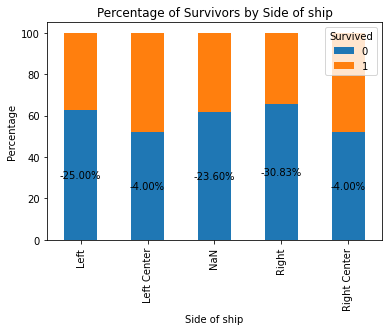

In [266]:
#Side of ship(left, left center, right center, right); no window = center
#left = even # room; right = odd # room
non_window = [127,125, 123, 121, 119, 117, 115, 109, 107, 105, 103, 101, 99, 97, 95, 53, 51, 49, 47, 45, 43, 3, 1, 5, 148, 146, 144, 142, 140, 138, 136, 134, 132, 130, 128, 126, 124, 122, 116, 114, 112, 110, 108, 104, 60, 58, 56, 54, 52, 50, 48, 41, 6, 4, 2]
total = np.arange(1,149)
window = [i for i in total if i not in non_window]

def assign_side(val):
    if val=="NA" or val=="T":
        return "NaN"
    elif int(val[1:]) in window:
        if int(val[1:])%2==0:
            return "Left"
        else:
            return "Right"
    else:
        if int(val[1:])%2==0:
            return "Left Center"
        else:
            return "Right Center"
        

clean_train['Side of ship'] = clean_train['New Cabin'].apply(assign_side)

def plot_percent_survivors(df, cat_col, binary_col):
    # Create a grouped dataframe with counts for each category and binary variable
    grouped_df = df.groupby([cat_col, binary_col])[binary_col].count().unstack()
    
    # Calculate the percentage of survivors for each category
    df_perc = grouped_df.apply(lambda x: x/x.sum()*100, axis=1)

    # Calculate the percentage difference between categories
    df_diff = df_perc.diff(axis=1).iloc[:,1]

    # Create a stacked bar chart
    df_perc.plot(kind='bar', stacked=True)

    # Add the percentage difference as text on the chart
    for i in range(len(df_diff)):
        plt.text(i, df_perc.iloc[i,0]/2, f'{df_diff[i]:.2f}%', ha='center', va='center')

    # Set the chart title and axis labels
    plt.title(f'Percentage of Survivors by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Percentage')
    plt.show()

plot_percent_survivors(clean_train, 'Side of ship', 'Survived')

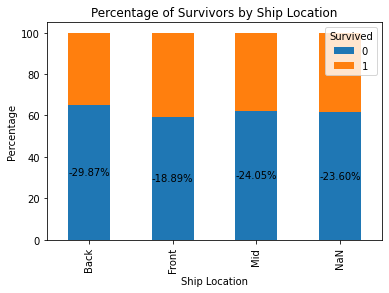

In [267]:
# ship location (front, mid, back, or NaN)

back = [102,100,98,96,94,92,90,88,86,84,82,80,78,76,148,146,144,142,140,138,136,134,132,130,128,126,117,119,121,123,125,127,93,91,89,87,85,83,81,79,77,75,73,71,69]
mid = [74,72,70,68,66,64,62,44,46,40,42,38,36,34,124,122,116,114,112,110,108,106,104,120,118,113,111,115,109,107,105,103,101,99,97,95,67,65,63,61,59,57,55,39,35,37]
front = [32,30,28,26,24,22,20,18,16,14,12,10,8,6,60,58,56,54,52,50,48,4,41,2,43,1,3,5,7,53,51,49,47,45,35,29,31,27,23,25,21,17,19,15,9,11]

def assign_location(val):
    if val=="NA" or val=="T":
        return "NaN"
    elif int(val[1:]) in back:
        return "Back"
    elif int(val[1:]) in mid:
        return "Mid"
    else:
        return "Front"

clean_train['Ship Location'] = clean_train['New Cabin'].apply(assign_location)
plot_percent_survivors(clean_train, 'Ship Location', 'Survived')

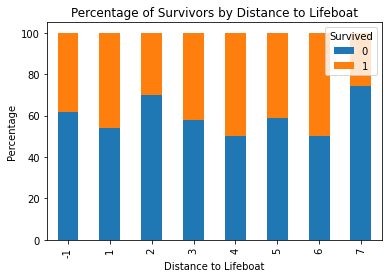

In [268]:
#Distance to lifeboat(top floor)

def distance(val):
    if val == 'NA' or val == 'T':
        return -1
    elif val[0] == 'A':
        return 1
    elif val[0] == 'B':
        return 2
    elif val[0] == 'C':
        return 3
    elif val[0] == 'D':
        return 4
    elif val[0] == 'E':
        return 5
    elif val[0] == 'F':
        return 6
    elif val[0] == 'G':
        return 7

def plot_percent_survivors_quant(df, cat_col, binary_col):
    # Create a grouped dataframe with counts for each category and binary variable
    grouped_df = df.groupby([cat_col, binary_col])[binary_col].count().unstack()
    
    # Calculate the percentage of survivors for each category
    df_perc = grouped_df.apply(lambda x: x/x.sum()*100, axis=1)

    # Calculate the percentage difference between categories
    df_diff = df_perc.diff(axis=1).iloc[:,1]

    # Create a stacked bar chart
    df_perc.plot(kind='bar', stacked=True)

    # Set the chart title and axis labels
    plt.title(f'Percentage of Survivors by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Percentage')
    plt.show()

clean_train['Distance to Lifeboat'] = clean_train['New Cabin'].apply(distance)
plot_percent_survivors_quant(clean_train, 'Distance to Lifeboat', 'Survived')

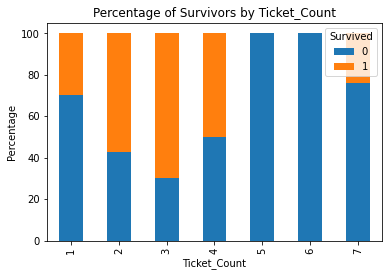

In [269]:
#number of ppl in a group
clean_train['Ticket_Count'] = clean_train['Ticket'].map(clean_train['Ticket'].value_counts())

plot_percent_survivors_quant(clean_train, 'Ticket_Count', 'Survived')

In [270]:

pd.set_option('display.max_columns', None)
clean_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,New Cabin,Fare_log,age_Pclass_median,fare_Pclass_median,age_Pclass_std,fare_Pclass_std,SibSp_count,Parch_count,fare_median_diff,Side of ship,Ship Location,Distance to Lifeboat,Ticket_Count
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NA,S,NA,2.110213,24.0,8.0500,10.632997,11.723991,491,491,-0.8000,NaN,NaN,-1,1
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,C85,4.280593,35.0,61.9792,14.590796,77.383157,216,216,9.3041,Right,Back,3,1
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,NA,2.188856,24.0,8.0500,10.632997,11.723991,491,491,-0.1250,NaN,NaN,-1,1
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,C123,3.990834,35.0,61.9792,14.590796,77.383157,216,216,-8.8792,Right Center,Back,3,2
4,0,3,male,35.0,0,0,373450,8.0500,NA,S,NA,2.202765,24.0,8.0500,10.632997,11.723991,491,491,0.0000,NaN,NaN,-1,1


**One-hot Encoding**

In [319]:
#Since only 2/7 columns are categorical, I'm using one-hot encoding since there won't be that much sparsity 
clean_train = pd.get_dummies(data=clean_train, columns=['Sex', 'Embarked'],drop_first=True)
clean_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


**Data Type Conversion**

In [321]:
#converting float to int for all columns that have whole number as float type
for col in clean_train.columns:
    if clean_train[col].dtype == 'float64' and all(clean_train[col].apply(lambda x: x.is_integer())):
        clean_train[col] = clean_train[col].astype(int)
clean_train.dtypes

Survived        int64
Pclass          int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Sex_male        uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object

# Cleaning test data

In [323]:
#clean_test = test.copy()
def clean(clean_test):
    clean_test = clean_test[clean_test['Fare']>0]
    clean_test = clean_test.drop(columns=['Ticket'])
    clean_test = clean_test.drop(columns=['Name'])
    clean_test = clean_test.drop(columns=['Cabin'])
    clean_test['Age'].fillna(clean_test['Age'].mode().iloc[0], inplace=True)
    clean_test['Embarked'].fillna(clean_test['Embarked'].mode().iloc[0], inplace=True)
    
    print(clean_test.iloc[152])
    print()
    ohe = OneHotEncoder(handle_unknown='ignore') 
    test_object = clean_test.select_dtypes('object')
    ohe.fit(test_object)
    codes = ohe.transform(test_object).toarray()
    feature_names = ohe.get_feature_names_out(['Sex', 'Embarked'])
    clean_test = pd.concat([clean_test.select_dtypes(exclude='object'), 
                   pd.DataFrame(codes,columns=feature_names)], axis=1)
    
    
    print(clean_test.iloc[152])
    print()
    #clean_test = clean_test.dropna() can't drop NA because submission requires 418 rows
    nan_mask = clean_test.isna().any(axis=1)

    # use the boolean mask to index the DataFrame and show only the rows with NaN values
    rows_with_nan = clean_test.loc[nan_mask]
    print(rows_with_nan)
    
    
    
    for col in clean_test.columns:
        if clean_test[col].dtype == 'float64' and all(clean_test[col].apply(lambda x: x.is_integer())):
            clean_test[col] = clean_test[col].astype(int)
            
    grouped_test = clean_test.groupby('Pclass')

    clean_test[['age_Pclass_median','fare_Pclass_median']] = grouped_test[['Age', 'Fare']].transform('median')
    clean_test[['age_Pclass_std','fare_Pclass_std']] = grouped_test[['Age', 'Fare']].transform('std')
    clean_test[['SibSp_count','Parch_count']] = grouped_test[['SibSp', 'Parch']].transform('count') 
    clean_test['fare_median_diff'] = clean_test['Fare']-clean_test['fare_Pclass_median']
    return clean_test

#clean_test = clean(clean_test)
#clean_test.shape

**Duplicates after cleaning**

In [324]:
#duplicate_rows = clean_test[clean_test.duplicated(keep=False)]
#print(duplicate_rows)

train_dup_rows = clean_train.duplicated()
test_dup_rows = clean_test.duplicated()



print(f'Number of Duplicated Rows: {train_dup_rows.sum()}')
print(f'Number of Duplicated Rows: {test_dup_rows.sum()}')
print(f'Shape of train data before dropping Survived col:{clean_train.shape}')
print(f'Shape of train data before dropping Survived col:{clean_test.shape}')

#removing duplicate rows
#clean_train = clean_train[~train_dup_rows]

Number of Duplicated Rows: 117
Number of Duplicated Rows: 0
Shape of train data before dropping Survived col:(891, 16)
Shape of train data before dropping Survived col:(418, 11)


# **Baseline Model**

In [175]:
#log regression; only using Pclass variable as it has highest correlation with Survived

y_train = clean_train['Survived']
x_train = clean_train.drop(columns=['Survived'])

x_test = clean_test.drop(columns=['PassengerId'])
ids = clean_test['PassengerId'].values


sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

baseline = LogisticRegression(class_weight="balanced")
baseline.fit(x_train, y_train)


predictions = logisticRegr.predict(x_test)

#submission file
sub = pd.DataFrame()
sub['PassengerId'] = ids.astype('int')
sub['Survived'] = predictions

subfolder_name = 'Submission'
filename = 'baseline.csv'
filepath = os.path.join(subfolder_name, filename)
sub.to_csv(filepath, index=False, float_format='%.5f')
print("Done!")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values